# Preview

In this example, we are going to use our toolbox to train and evaluate the [Trajectory-based Dynamics Model](https://arxiv.org/abs/2012.09156) in the reacher environment.

In [83]:
from IPython import display
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
import omegaconf

import mbrl.env.pets_reacher as reacher_env
import mbrl.env.cartpole_continuous as cartpole_env
import mbrl.env.reward_fns as reward_fns
import mbrl.env.termination_fns as termination_fns
import mbrl.models as models
import mbrl.planning as planning
import mbrl.util.common as common_util


%load_ext autoreload
%autoreload 2

mpl.rcParams.update({"font.size": 16})

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Creating the environment

First we instantiate the environment.

In [3]:
seed = 0
env = reacher_env.Reacher3DEnv()
env.seed(seed)
rng = np.random.default_rng(seed=0)
generator = torch.Generator(device=device)
generator.manual_seed(seed)
obs_shape = env.observation_space.shape
act_shape = env.action_space.shape


# PID Agent

The following config object and the subsequent function call create an agent that can plan using the Cross-Entropy Method over the model environment created above. When calling `planning.create_trajectory_optim_agent_for_model`, we also specify how many particles to use when propagating model uncertainty, as well as the uncertainty propagation method, "fixed_model", which corresponds to the method TS$\infty$ in the PETS paper.

In [71]:
def create_pid_agent(action_dim):
    P = np.random.rand(action_dim) * 5
    I = np.zeros(action_dim)
    D = np.random.rand(action_dim)
    target = np.random.rand(action_dim) * 2 - 1

    agent = planning.PIDAgent(dim=action_dim, Kp=P, Ki=I, Kd=D, target=target)
    return agent

In [72]:
agent = create_pid_agent(env.action_space.shape[0])

# Hydra configuration

MBRL-Lib uses [Hydra](https://github.com/facebookresearch/hydra) to manage configurations. For the purpose of this example, you can think of the configuration object as a dictionary with key/value pairs--and equivalent attributes--that specify the model and algorithmic options. Our toolbox expects the configuration object to be organized as follows:

In [109]:
trial_length = 100
num_trials = 100
ensemble_size = 5
param_shape = (len(agent.get_parameters())+1,)

# Everything with "???" indicates an option with a missing value.
# Our utility functions will fill in these details using the 
# environment information
cfg_dict = {
    # dynamics model configuration
    "dynamics_model": {
        "_target_": "mbrl.models.GaussianMLP",
        "device": device,
        "num_layers": 3,
        "ensemble_size": ensemble_size,
        "hid_size": 200,
        "in_size": param_shape[0]+obs_shape[0], # control params, horizon, state_0
        "out_size": obs_shape[0],               # state time 0+h
        "deterministic": False,
        "propagation_method": "fixed_model",
        # can also configure activation function for GaussianMLP
        "activation_fn_cfg": {
            "_target_": "torch.nn.LeakyReLU",
            "negative_slope": 0.01
        }
    },
    # options for training the dynamics model
    "algorithm": {
        "learned_rewards": False,
        "target_is_delta": False, # trajectory based model predicts states directly
        "normalize": True,
    },
    # these are experiment specific options
    "overrides": {
        "trial_length": trial_length,
        "num_steps": num_trials * trial_length,
        "model_batch_size": 32,
        "validation_ratio": 0.05
    }
}
cfg = omegaconf.OmegaConf.create(cfg_dict)

# Creating a dynamics model

Given the configuration above, the following two lines of code create a wrapper for 1-D transition reward models, and a gym-like environment that wraps it, which we can use for simulating the real environment. The 1-D model wrapper takes care of creating input/output data tensors to the underlying NN model (by concatenating observations, actions and rewards appropriately), normalizing the input data to the model, and other data processing tasks (e.g., converting observation targets to deltas with respect to the input observation).

In [110]:
# Create a 1-D dynamics model for this environment
dynamics_model = common_util.create_one_dim_tr_model(cfg, obs_shape, act_shape)


# Create a replay buffer

We can create a replay buffer for this environment an configuration using the following method, where `collect_trajectories` is on for easier plotting of results.

In [111]:
collect_full_trajectories = True
replay_buffer = common_util.create_replay_buffer(cfg, 
                                                 obs_shape, 
                                                 param_shape, 
                                                 rng=rng, 
                                                 collect_trajectories=collect_full_trajectories)

We can now populate the replay buffer with random trajectories of a desired length, using a modified function based on `util.rollout_agent_trajectories`. The changes are that the tuples are only added to the buffer at the end of the trajectory to add every sub-trajectory for supervised learning.

In [112]:
step = 0
trial = 0
total_rewards = []
callback = None
while trial < num_trials:
    traj = []
    obs = env.reset()
    
    # create a new agent each trial to get a variety of PID parameters
    agent = create_pid_agent(env.action_space.shape[0])
    agent.reset()
    done = False
    total_reward = 0.0
    while not done:
        action = agent.act(obs)
        next_obs, reward, done, info = env.step(action)
        if callback:
            callback((obs, action, next_obs, reward, done))

        obs = next_obs
        traj.append((obs, step))
        
        # if not the first step, iterate through memory and append each sub-trajectory
        if len(traj[:-1]) > 0:
            for obs_t, t in traj[:-1]:
#                 print(f"adding: mem time {t}, current time {step}, horizon {step-t}")
                replay_buffer.add(obs_t, np.concatenate((agent.get_parameters(), np.array([step-t,]))), next_obs, reward, done)

        total_reward += reward
        step += 1
                
        if not collect_full_trajectories and step == steps_or_trials_to_collect:
            total_rewards.append(total_reward)
            break
        if trial_length and step % trial_length == 0:
            if collect_full_trajectories and not done and replay_buffer is not None:
                replay_buffer.close_trajectory()
            break
    trial += 1
    total_rewards.append(total_reward)
    


# Training the Trajectory Based Model

Create a basic model trainer for our Gaussian MLP.

In [113]:
model_trainer = models.ModelTrainer(dynamics_model, optim_lr=1e-4, weight_decay=5e-5)

Create a training & validation dataset.

In [114]:
train_dataset, val_dataset = common_util.get_basic_buffer_iterators(
    replay_buffer, cfg["overrides"]["model_batch_size"], .1, ensemble_size=ensemble_size, shuffle_each_epoch=True)


Train the model!

In [115]:
train_losses, val_losses = model_trainer.train(train_dataset, val_dataset, num_epochs=50, patience=100)

# Plotting Results

## Model Loss

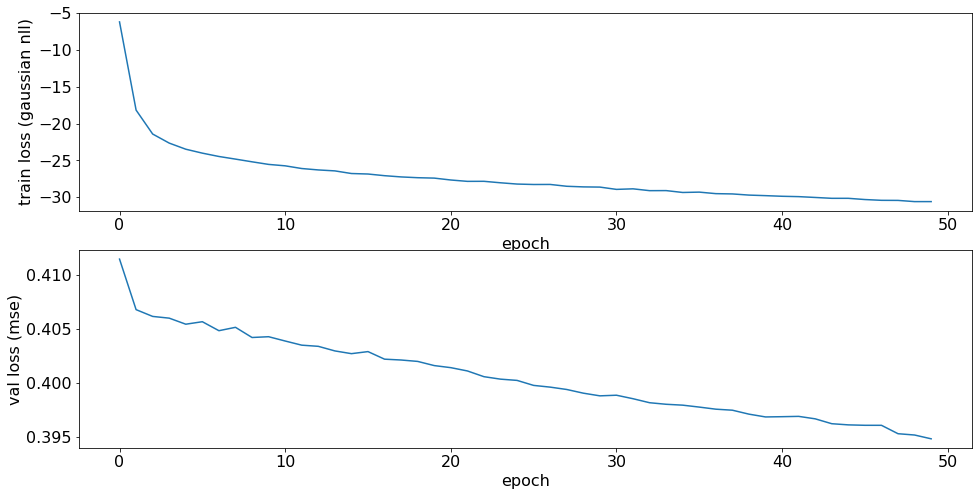

In [116]:
fig, ax = plt.subplots(2, 1, figsize=(16, 8))
ax[0].plot(train_losses)
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("train loss (gaussian nll)")
ax[1].plot(val_losses)
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("val loss (mse)")
plt.show()